# Clustering 


### 1. Shape-based clustering 
In the tslearn package are available different clustering methods for time series, such as k-means. 

Following the same structure of the tabular case, we should select the best k by exploiting the elbow method. 


In [1]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks
import matplotlib.pyplot as plt
import zlib
import numpy as np

Create a set of time series by exploiting the function random_walks:

In [2]:
X = random_walks(n_ts=60, sz=40)

In [3]:
X.shape

(60, 40, 1)

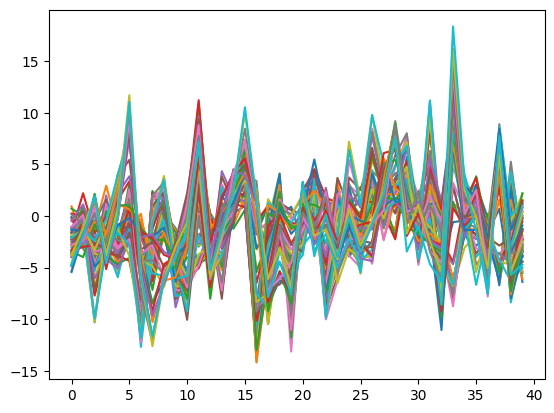

In [4]:
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

Apply the k-means to the time series just generated. 

In [5]:
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=10, random_state=0)
km.fit(X)

TimeSeriesKMeans(max_iter=10, n_clusters=5, random_state=0)

Plot the cluster centers to see if there are differences among the different centroids.

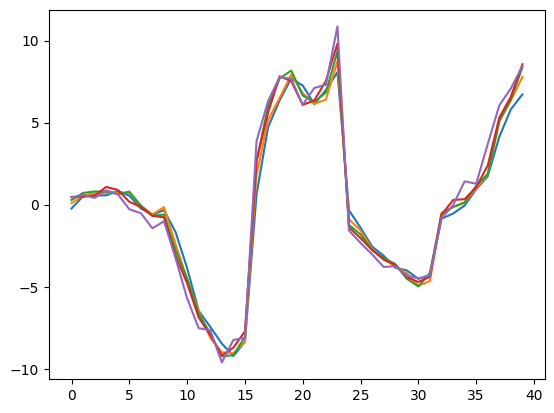

In [6]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

We can change the metric to see if we can separate better the clusters

In [7]:
km_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0)

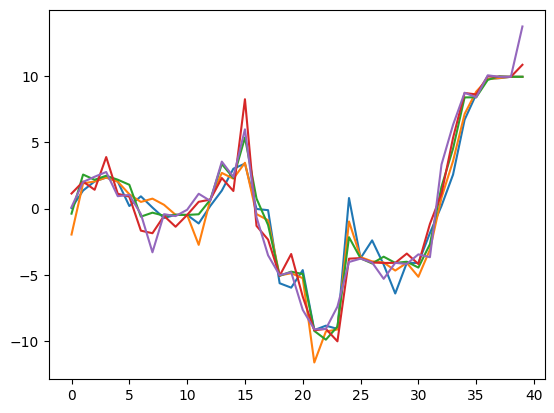

In [8]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

In [9]:
km.inertia_

181.79792982819197

In [10]:
km_dtw.inertia_

43.79258492306568

### 2. Feature-based clustering 
We can apply the clustering to the features extracted. In this case the clustering tecnique applied is the tabular one. 

In [11]:
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [12]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(F)

KMeans(n_clusters=5, n_init=10)

Compute the centroid of series assigned to a certain cluster from the series. This is because from a centroid, which is a point in the feature space, we cannot retrieve a time series through a direct inverse transformation.

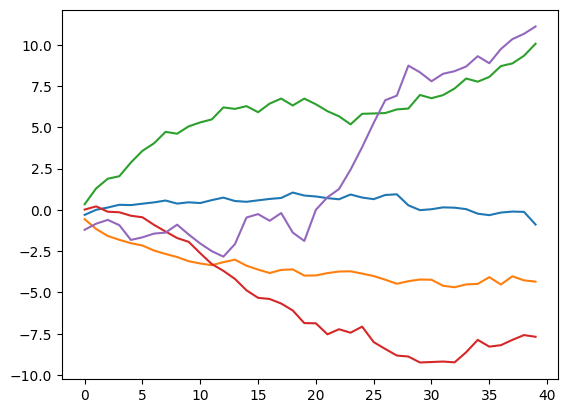

In [14]:
for i in range(5):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [15]:
kmeans.inertia_

1438.5507972685255

### 3. Compression-based clustering 


In [16]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [17]:
from sklearn.metrics import pairwise_distances
import zlib
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [18]:
M

array([[0.51903553, 0.98348158, 0.98101266, ..., 0.97864322, 0.98965071,
        0.97481108],
       [0.98348158, 0.52035623, 0.98225602, ..., 0.98113208, 0.99093264,
        0.98108449],
       [0.98101266, 0.98225602, 0.51767677, ..., 0.97869674, 0.9883871 ,
        0.97613065],
       ...,
       [0.97864322, 0.98113208, 0.97869674, ..., 0.51616915, 0.99103713,
        0.97880299],
       [0.98965071, 0.99093264, 0.9883871 , ..., 0.99103713, 0.5171504 ,
        0.98459564],
       [0.97481108, 0.98108449, 0.97613065, ..., 0.97880299, 0.98459564,
        0.52      ]])

In [19]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(eps=0.965, metric='precomputed')

In [20]:
from tslearn.piecewise import PiecewiseAggregateApproximation
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

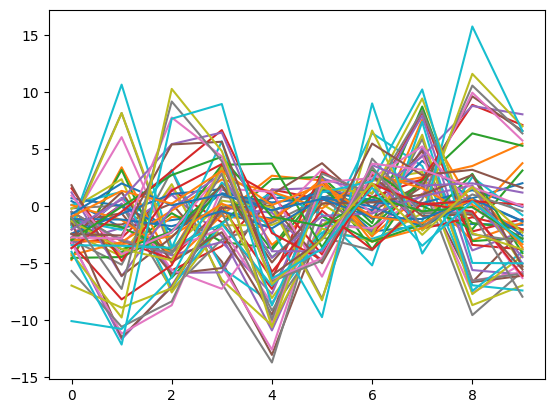

In [21]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [22]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_paa)

TimeSeriesKMeans(max_iter=5, random_state=0)

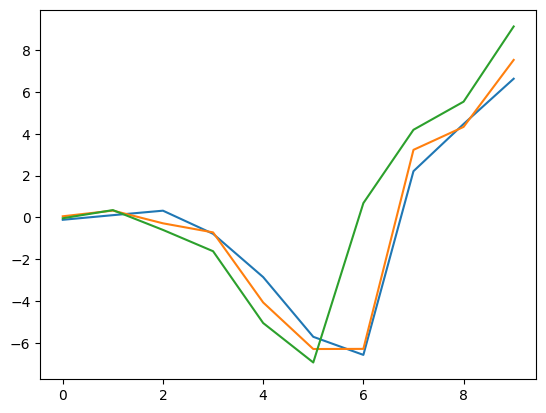

In [23]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 3))
plt.show()

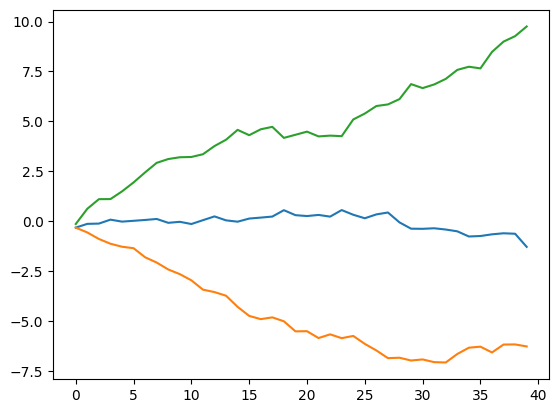

In [24]:
import numpy as np
for i in range(3):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()